# Computer Vision
Here the CMM networks will be described and compared with Fully connected layers. All algorithm will be shown on example from real food image database 

Below all steps will be demonstrated one by one

# Import dataset

In [2]:
import zipfile

# Dowload a dataset in .zip
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip 

# Unpack / unzip dataset
zip_ref = zipfile.ZipFile("pizza_steak.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2022-05-16 23:05:30--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.218.128, 142.250.153.128, 74.125.143.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.218.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109540975 (104M) [application/zip]
Saving to: ‘pizza_steak.zip’

pizza_steak.zip     100%[===================>] 104.47M  52.0MB/s    in 2.0s    

2022-05-16 23:05:33 (52.0 MB/s) - ‘pizza_steak.zip’ saved [109540975/109540975]



# Visualize data
The dataset has been downloaded. To start working with it we must get know more about itself. To do so we must visualize data. To visualize it we must find how to open/operate with downloaded dataset first

**Database structure**

In [25]:
# Look what is inside of downloaded database folder
!ls pizza_steak

test  train


In [27]:
!ls pizza_steak/train

pizza  steak


In [3]:
s = !ls pizza_steak/train/pizza
print("Data type of list in folder: ", type(s))
print("First 50 characters of list: \n", s.nlstr[0:50])

Data type of list in folder:  <class 'IPython.utils.text.SList'>
First 50 characters of list: 
 1008104.jpg  1638227.jpg  2235981.jpg  2774899.jpg


In [4]:
# Browse whole database folder
# with os.walk
import os

for root, dirs, files in os.walk("pizza_steak"):
  print(f"There are #{len(dirs)} directories and #{len(files)} files In the directory {root}")

There are #2 directories and #0 files In the directory pizza_steak
There are #2 directories and #0 files In the directory pizza_steak/test
There are #0 directories and #250 files In the directory pizza_steak/test/steak
There are #0 directories and #250 files In the directory pizza_steak/test/pizza
There are #2 directories and #0 files In the directory pizza_steak/train
There are #0 directories and #750 files In the directory pizza_steak/train/steak
There are #0 directories and #750 files In the directory pizza_steak/train/pizza


Now the structure of database seems to be more clear
```
Example of file structure

pizza_steak <- top level folder
└───train <- training images
│   └───pizza
│   │   │   1008104.jpg
│   │   │   1638227.jpg
│   │   │   ...      
│   └───steak
│       │   1000205.jpg
│       │   1647351.jpg
│       │   ...
│   
└───test <- testing images
│   └───pizza
│   │   │   1001116.jpg
│   │   │   1507019.jpg
│   │   │   ...      
│   └───steak
│       │   100274.jpg
│       │   1653815.jpg
│       │   ...    
 ```


**Load variables**

First of all, we are getting names of classes programmatically

In [5]:
# Get the class names (programmatically, this is much more helpful with a longer list of classes)
import pathlib
import numpy as np
data_dir = pathlib.Path("pizza_steak/train/") # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

['pizza' 'steak']


Now we create a helper function to view a random image from the set

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

Run the cell below to view a random image

Image shape: (354, 512, 3)


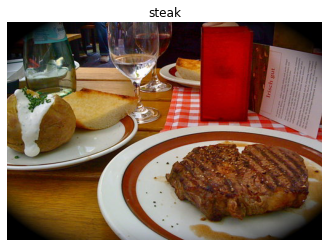

In [7]:
img = view_random_image(target_dir="pizza_steak/train/",
                        target_class="steak")

# CNN - Convolutional Neural Networks

### Typical architecture of a convolutional neural network

Convolutional neural networks are no different to other kinds of deep learning neural networks in the fact they can be created in many different ways. What you see below are some components you'd expect to find in a traditional CNN.

Components of a convolutional neural network:

| **Hyperparameter/Layer type** | **What does it do?** | **Typical values** |
| ----- | ----- | ----- |
| Input image(s) | Target images you'd like to discover patterns in| Whatever you can take a photo (or video) of |
| Input layer | Takes in target images and preprocesses them for further layers | `input_shape = [batch_size, image_height, image_width, color_channels]` |
| Convolution layer | Extracts/learns the most important features from target images | Multiple, can create with [`tf.keras.layers.ConvXD`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) (X can be multiple values) |
| Hidden activation | Adds non-linearity to learned features (non-straight lines) | Usually ReLU ([`tf.keras.activations.relu`](https://www.tensorflow.org/api_docs/python/tf/keras/activations/relu)) |
| Pooling layer | Reduces the dimensionality of learned image features | Average ([`tf.keras.layers.AvgPool2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/AveragePooling2D)) or Max ([`tf.keras.layers.MaxPool2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D)) |
| Fully connected layer | Further refines learned features from convolution layers | [`tf.keras.layers.Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) |
| Output layer | Takes learned features and outputs them in shape of target labels | `output_shape = [number_of_classes]` (e.g. 3 for pizza, steak or sushi)|
| Output activation | Adds non-linearities to output layer | [`tf.keras.activations.sigmoid`](https://www.tensorflow.org/api_docs/python/tf/keras/activations/sigmoid) (binary classification) or [`tf.keras.activations.softmax`](https://www.tensorflow.org/api_docs/python/tf/keras/activations/softmax) |

How they stack together:

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-simple-convnet.png)
*A simple example of how you might stack together the above layers into a convolutional neural network. Note the convolutional and pooling layers can often be arranged and rearranged into many different formations.*

What we know so far abot data:

1.   It has 2 classes
2.   Train consists of 750 samples for each class and test has 250
3.   The samples has 3 colours but differ in size

From the paper on dataset we know that RF deals with classification with 50.76%, but we reduced classes to two, so we can't really compare them

Usually we build a baseline (RF) and then trying to beat it with new model



In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the seed
tf.random.set_seed(42)

# Preprocess data (get all of the pixel values between 1 and 0, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Setup the train and test directories
train_dir = "pizza_steak/train/"
test_dir = "pizza_steak/test/"

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=32, # number of images to process at a time 
                                               target_size=(224, 224), # convert all images to be 224 x 224
                                               class_mode="binary", # type of problem we're working on
                                               seed=42)

valid_data = valid_datagen.flow_from_directory(test_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               seed=42)

# Create a CNN model (same as Tiny VGG - https://poloclub.github.io/cnn-explainer/)
model_1 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=10, 
                         kernel_size=3, # can also be (3, 3)
                         activation="relu", 
                         input_shape=(224, 224, 3)), # first layer specifies input shape (height, width, colour channels)
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2, # pool_size can also be (2, 2)
                            padding="valid"), # padding can also be 'same'
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"), # activation='relu' == tf.keras.layers.Activations(tf.nn.relu)
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1, activation="sigmoid") # binary activation output
])

# Compile the model
model_1.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_1 = model_1.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/5
47/47 [==============================] - 77s 2s/step - loss: 0.5730 - accuracy: 0.6920 - val_loss: 0.4005 - val_accuracy: 0.8420
Epoch 2/5
47/47 [==============================] - 88s 2s/step - loss: 0.4192 - accuracy: 0.8180 - val_loss: 0.3371 - val_accuracy: 0.8540
Epoch 3/5
47/47 [==============================] - 75s 2s/step - loss: 0.4171 - accuracy: 0.8060 - val_loss: 0.3337 - val_accuracy: 0.8500
Epoch 4/5
47/47 [==============================] - 89s 2s/step - loss: 0.3646 - accuracy: 0.8393 - val_loss: 0.3258 - val_accuracy: 0.8780
Epoch 5/5
47/47 [==============================] - 75s 2s/step - loss: 0.3292 - accuracy: 0.8700 - val_loss: 0.3160 - val_accuracy: 0.8640


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 10)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 10)       0         
 2D)                                                    

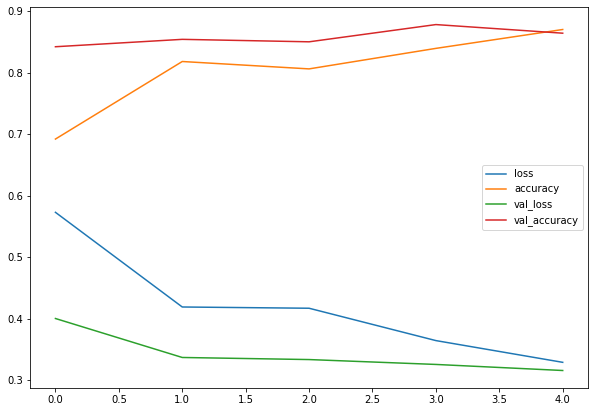

In [9]:
import pandas as pd
pd.DataFrame(history_1.history).plot(figsize=(10,7));

model_1.summary()

# CNN vs FeedForward
To realise advantages of CNN the results will be compared to feedworward neural networks

In [11]:
# Define a FeedForward Neural Network
# Set the architecture of 4 hidden layers with 100 neurons
model_2 = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(100, activation="relu"),                                      
  tf.keras.layers.Dense(100, activation="relu"),
  tf.keras.layers.Dense(100, activation="relu"),
  tf.keras.layers.Dense(100, activation="relu"),
  tf.keras.layers.Dense(1, activation="softmax")                                   
])

# Compile the model
# Set the Adam optimizer, define the loss to be crossentropy, 
# set to record accuracy
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model and record metrics for epochs
history_2 = model_2.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Epoch 1/5
47/47 [==============================] - 11s 225ms/step - loss: 2.3520 - accuracy: 0.5000 - val_loss: 1.8499 - val_accuracy: 0.5000
Epoch 2/5
47/47 [==============================] - 10s 219ms/step - loss: 0.8831 - accuracy: 0.5000 - val_loss: 0.8717 - val_accuracy: 0.5000
Epoch 3/5
47/47 [==============================] - 10s 218ms/step - loss: 0.8432 - accuracy: 0.5000 - val_loss: 0.5351 - val_accuracy: 0.5000
Epoch 4/5
47/47 [==============================] - 10s 217ms/step - loss: 0.5612 - accuracy: 0.5000 - val_loss: 0.5918 - val_accuracy: 0.5000
Epoch 5/5
47/47 [==============================] - 10s 217ms/step - loss: 0.5264 - accuracy: 0.5000 - val_loss: 0.4466 - val_accuracy: 0.5000


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, None)              0         
                                                                 
 dense_1 (Dense)             (None, 100)               15052900  
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 100)               10100     
                                                                 
 dense_4 (Dense)             (None, 100)               10100     
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                                                 
Total params: 15,083,301
Trainable params: 15,083,301


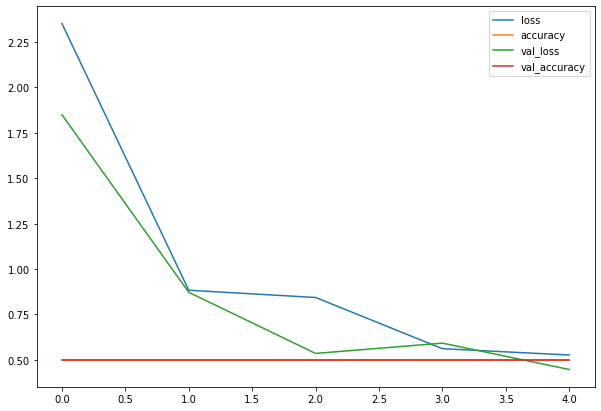

In [12]:
model_2.summary()
pd.DataFrame(history_2.history).plot(figsize=(10,7));

In [13]:
# Define a FeedForward Neural Network
# Set the architecture of 4 hidden layers with more neurons
model_3 = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(200, activation="relu"),                                      
  tf.keras.layers.Dense(500, activation="relu"),
  tf.keras.layers.Dense(500, activation="relu"),
  tf.keras.layers.Dense(200, activation="relu"),
  tf.keras.layers.Dense(1, activation="sigmoid")                                   
])

# Compile the model
# Set the Adam optimizer, define the loss to be crossentropy, 
# set to record accuracy
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model and record metrics for epochs
history_3 = model_3.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Epoch 1/5
47/47 [==============================] - 11s 227ms/step - loss: 4.4578 - accuracy: 0.5927 - val_loss: 0.4992 - val_accuracy: 0.7580
Epoch 2/5
47/47 [==============================] - 10s 221ms/step - loss: 0.5799 - accuracy: 0.7280 - val_loss: 0.6375 - val_accuracy: 0.6860
Epoch 3/5
47/47 [==============================] - 10s 223ms/step - loss: 0.5157 - accuracy: 0.7580 - val_loss: 0.4560 - val_accuracy: 0.7780
Epoch 4/5
47/47 [==============================] - 10s 219ms/step - loss: 0.4888 - accuracy: 0.7793 - val_loss: 0.4523 - val_accuracy: 0.7860
Epoch 5/5
47/47 [==============================] - 10s 221ms/step - loss: 0.4756 - accuracy: 0.7820 - val_loss: 0.4458 - val_accuracy: 0.7940


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, None)              0         
                                                                 
 dense_6 (Dense)             (None, 200)               30105800  
                                                                 
 dense_7 (Dense)             (None, 500)               100500    
                                                                 
 dense_8 (Dense)             (None, 500)               250500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 1)                 201       
                                                                 
Total params: 30,557,201
Trainable params: 30,557,201


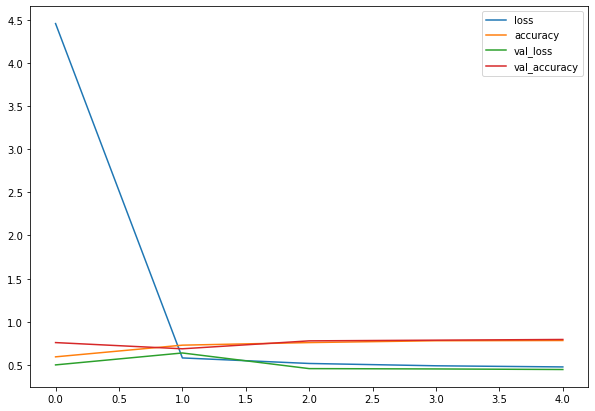

In [14]:
model_3.summary()
pd.DataFrame(history_3.history).plot(figsize=(10,7));

In [15]:
# Define a FeedForward Neural Network
# Set the architecture of 4 hidden layers with more neurons
model_4 = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(200, activation="relu"),                                      
  tf.keras.layers.Dense(500, activation="relu"),
  tf.keras.layers.Dense(500, activation="relu"),
  tf.keras.layers.Dense(200, activation="relu"),
  tf.keras.layers.Dense(1, activation="sigmoid")                                   
])

# Compile the model
# Set the Adam optimizer, define the loss to be crossentropy, 
# set to record accuracy
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model and record metrics for epochs
history_4 = model_4.fit(train_data,
                        epochs=25,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Epoch 1/25
47/47 [==============================] - 11s 228ms/step - loss: 4.9029 - accuracy: 0.5747 - val_loss: 0.5574 - val_accuracy: 0.6940
Epoch 2/25
47/47 [==============================] - 10s 221ms/step - loss: 0.5777 - accuracy: 0.7167 - val_loss: 0.4651 - val_accuracy: 0.7760
Epoch 3/25
47/47 [==============================] - 10s 221ms/step - loss: 0.4759 - accuracy: 0.7807 - val_loss: 0.4505 - val_accuracy: 0.7880
Epoch 4/25
47/47 [==============================] - 10s 222ms/step - loss: 0.5131 - accuracy: 0.7560 - val_loss: 0.5552 - val_accuracy: 0.7680
Epoch 5/25
47/47 [==============================] - 10s 218ms/step - loss: 0.4907 - accuracy: 0.7720 - val_loss: 0.4401 - val_accuracy: 0.7840
Epoch 6/25
47/47 [==============================] - 10s 221ms/step - loss: 0.4169 - accuracy: 0.8040 - val_loss: 0.4606 - val_accuracy: 0.7820
Epoch 7/25
47/47 [==============================] - 10s 220ms/step - loss: 0.4656 - accuracy: 0.7780 - val_loss: 0.4725 - val_accuracy: 0.7740

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, None)              0         
                                                                 
 dense_11 (Dense)            (None, 200)               30105800  
                                                                 
 dense_12 (Dense)            (None, 500)               100500    
                                                                 
 dense_13 (Dense)            (None, 500)               250500    
                                                                 
 dense_14 (Dense)            (None, 200)               100200    
                                                                 
 dense_15 (Dense)            (None, 1)                 201       
                                                                 
Total params: 30,557,201
Trainable params: 30,557,201


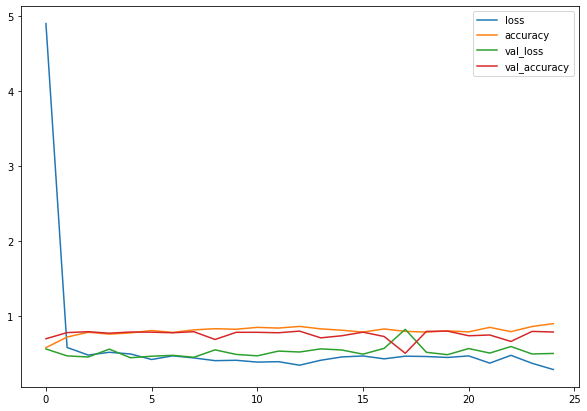

In [16]:
model_4.summary()
pd.DataFrame(history_4.history).plot(figsize=(10,7));

It is clearly seen that increase in epochs doesn't benefit. Moreover, after 10 epichs the validation error starts rising fast which could be the result of overfitting.

***Summary***

1 CNN was tried and 3 Feed Forward NN were tried as well. Here are the results

Model | Parameters | Validation Accuracy | Epochs
--- | :---: | :---: | :---:
CNN | 31k | 87.8% | 5
FNN | 15M | 50% | 5 
FNN | 30M | 70% | 5
FNN | 30M | 74% | 25

So, as it could be observed from the table above, FNN even with 1000 times more parameters achieves less performance accuracy then CNN

> ⚡ It leads to another important consequence: "*More parameters - better*" isn't working. While it could be the case in other examples, here it is clear that CNN has less parameters and less possible patterns to learn, but it learns special and important, invariant to transition parameters which is more valuable in image analysis.




# Going down in CNN

## Part: 1 - Visualise data

Image shape: (512, 512, 3)
Image shape: (512, 512, 3)


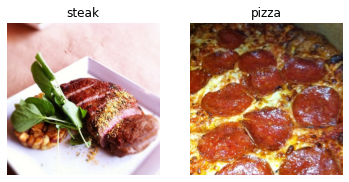

In [22]:
plt.figure()
plt.subplot(1,2,1)
steak_img = view_random_image("pizza_steak/train/", "steak")
#plt.imshow(steak_img)
plt.subplot(1,2,2)
pizza_img = view_random_image("pizza_steak/train/", "pizza")
#plt.imshow(pizza_img)
#plt.show()

## Part: 2 - Preprocess the data

Here usually data divides to `training`, `validation` and `testing` sets. And a basic preprocessing applies here, in our case it is scaling (normalization)

In this particular database objects are already divided on sets. So the pathes to them are:

In [10]:
train_dir = "pizza_steak/train/"
test_dir  = "pizza_steak/test/"

Now we prepare a generators to normalize data

Image generators will be applied right before passing data into the model

They have much more parameters and options for data augmentation (shift, zoom, rescale, flip, change color, etc)

In [11]:
# Rescale generators
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen  = ImageDataGenerator(rescale = 1/255.)

Next step is to turn our data into ***batches***.

A ***batch*** is a mini set of data which model is using to look at at the same time. Let's say we have a batches of 16 images and we set 5 epochs. After diciding the data into batches we got 50 batches. It means each batch, one by one will go into a model to calculate the loss separately and all the batches will come again in next epochs. And again, and again (5 times)


> **Rule:** Batches number must be less then 32 


One of the advantages of using ImageDataGenerator is that it can reshape all images to the same resolution (named target_size). It is important as the images in given database are differ in resolution

In [15]:
# Create batches
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               target_size = (224,224),
                                               class_mode = 'binary',
                                               batch_size = 32)
test_data = test_datagen.flow_from_directory(directory=test_dir,
                                               target_size = (224,224),
                                               class_mode = 'binary',
                                               batch_size = 32)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [36]:
images, labels = train_data.next()
len(images), len(labels), images.shape, labels.shape

(32, 32, (32, 224, 224, 3), (32,))

So, according to the shapes above we see that train_data holds batches sized as 32 objects. We can see it as length on labels and images equals to 32.

Looking at the images shape it is clear that there are 32 images with the same resolution of 224x224 which have 3 colours.

In [42]:
images[5]

array([[[0.15686275, 0.07058824, 0.16078432],
        [0.16470589, 0.07058824, 0.16470589],
        [0.16470589, 0.07058824, 0.16470589],
        ...,
        [0.16470589, 0.06666667, 0.15294118],
        [0.16470589, 0.07058824, 0.15686275],
        [0.1764706 , 0.08235294, 0.1764706 ]],

       [[0.16470589, 0.07058824, 0.16470589],
        [0.16862746, 0.07450981, 0.16862746],
        [0.16862746, 0.07450981, 0.16862746],
        ...,
        [0.15294118, 0.04313726, 0.12941177],
        [0.14901961, 0.0509804 , 0.13333334],
        [0.15686275, 0.05882353, 0.14117648]],

       [[0.15686275, 0.0627451 , 0.15686275],
        [0.16078432, 0.06666667, 0.16078432],
        [0.16078432, 0.06666667, 0.16078432],
        ...,
        [0.14509805, 0.03137255, 0.10196079],
        [0.14901961, 0.03921569, 0.09803922],
        [0.15294118, 0.04313726, 0.10196079]],

       ...,

       [[0.19607845, 0.01176471, 0.04313726],
        [0.19607845, 0.01176471, 0.04313726],
        [0.19607845, 0

> Above is representation of one of the images kept in batch. It is seen that it was normalized (0 to 1)



In [43]:
labels

array([0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0.,
       1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1.],
      dtype=float32)

As expected, labels are binary numbers - 1 and 0. Which represents the pizza class and steak class

## Part: 3 - Building a model

We will start with basic model consisting with just 3 Conv layers and then we will increase complexity with cheching of the improvement. 

Basically, we are starting with creation of **baseline**

> 🔑 **Note:** In Deep Learning there are almost infoinite number of architectures you could create. So, one of the best ways to get started is to create a simple baseline and check if it is working with data. Then the architecture could become more complex and more reasonable, based on the baseline. To increase complexity the **research** of currently the best models is required. For example, a search of best current architecture for image classification can tell you how to create a good neural network for the field.

Sources to look at for a research


1.   Google scholar
2.   Papers with code





In [12]:
# Making a model in easier way with many imports
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential

# Create a 3 Conv Layers Baseline model
model_base = Sequential([
  Conv2D(filters = 10,
         kernel_size = 3,
         strides = 1,
         padding = 'valid',
         activation = 'relu',
         input_shape = (224,224,3)),
  Conv2D(10, 3, activation = 'relu'),
  Conv2D(10, 3, activation = 'relu'),
  Flatten(),
  Dense(1, activation="sigmoid")                                  
])

# Compile a model
model_base.compile(loss="binary_crossentropy",
                   optimizer = Adam(),
                   metrics = ["accuracy"])

# Check the architecture and number of parameters
model_base.summary()
print("Number of train and test batches of 32 images: ", len(train_data), len(test_data))


# Train the model
history_base = model_base.fit(train_data, # Combination of images and labels
                              epochs = 5,
                              steps_per_epoch = len(train_data), # Go through all batches for each of epochs *Could be changed!*
                              validation_data = test_data,
                              validation_steps = len(test_data),
                              ) # callback = [tensorboard_callback] This callback helps plotting metrics

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 conv2d_5 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 conv2d_6 (Conv2D)           (None, 218, 218, 10)      910       
                                                                 
 flatten_1 (Flatten)         (None, 475240)            0         
                                                                 
 dense_1 (Dense)             (None, 1)                 475241    
                                                                 
Total params: 477,341
Trainable params: 477,341
Non-trainable params: 0
_________________________________________________________________


NameError: ignored

In [50]:
model_1.evaluate(test_data)

16/16 [==============================] - 2s 142ms/step - loss: 0.3139 - accuracy: 0.8780


[0.3139161467552185, 0.878000020980835]

In [51]:
model_base.evaluate(test_data)

16/16 [==============================] - 2s 142ms/step - loss: 0.6305 - accuracy: 0.7560


[0.6304697394371033, 0.7559999823570251]

***Summary***: So, we built a baseline. It has 477k parameters and it performs with 75% accuracy. While the first model that we built with VGG architecture has 31k parameters and accuracy of 87%. There is definitely a way to increase a performance of current baseline. And this will be the aim of next sections

But first, a bit of `evaluation` of models. We will see *overfitting*

## Part: 4 - Evaluation

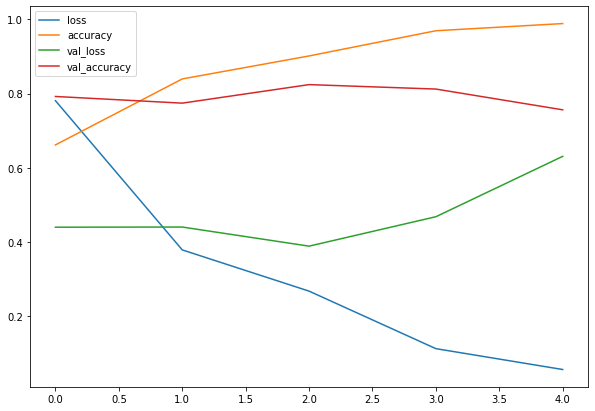

In [53]:
# Plot learning curves
import pandas as pd
pd.DataFrame(history_base.history).plot(figsize=(10,7))

After the epoch #2 the validation loss starts increasing and validation accuracy dropping. It is due to the **overfitting**

It is a bit hard to see in the figure abive because there are too many lines

In [58]:
pd.DataFrame(history_base.history)

,loss,accuracy,val_loss,val_accuracy
0,0.780674,0.661333,0.439301,0.792
1,0.378059,0.839333,0.439748,0.774
2,0.266837,0.901333,0.388202,0.824
3,0.111628,0.969333,0.467571,0.812
4,0.055385,0.988667,0.630470,0.756


In [14]:
# Plot validation and training curves separately
def plot_loss_curves(my_history):
  """
  Plots separate figures for training and validation metrics
  It is a helper function
  """
  loss = my_history.history["loss"]
  accuracy = my_history.history["accuracy"]
  val_loss = my_history.history["val_loss"]
  val_accuracy = my_history.history["val_accuracy"]

  epochs = range(len(loss))  # Length of any training metric gives the number of epochs

  # Plot Loss
  plt.figure(figsize=(20,7))
  plt.subplot(1,2,1)
  plt.plot(epochs, loss,     label = "Training Loss"  )
  plt.plot(epochs, val_loss, label = "Validation Loss")
  plt.title("Loss")
  plt.xlabel("epochs")
  plt.legend()

  # Plot Accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs, accuracy,     label = "Training Accuracy"  )
  plt.plot(epochs, val_accuracy, label = "Validation Accuracy")
  plt.title("Accuracy")
  plt.xlabel("epochs")
  plt.legend()

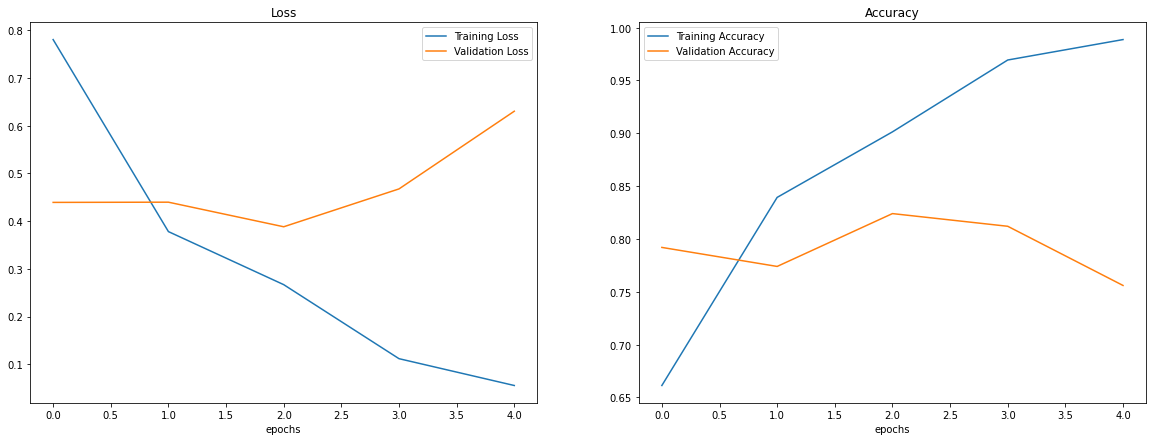

In [79]:
plot_loss_curves(history_base)

> Now the **overfittin** can't be unseen. It is obvious the model trains to classify only training data, but it doesn't *generalize* rules for other data. The evidence for it is a low train error with *high validation error*

## Part: 5 - Updating a model: Regularization

We difined a problem with a model, it overfitts, it has many parameters and the accuracy could be better.

What could be a reason of overfitting:

* Increase the number of Conv layers (Make it deeper, more prefered)
* Increase the number of filters in Conv layers (Make it wider)
* Add another Dense layer at the end

Ways to deal with overfitting:

* Add data augmentation
* Add regularization layers (like Pooling)
* Add more data

To deal with some of the problems the pooling layer could be used

> 💪 While the *Convolutional* layer finds features in the image, *MaxPooling* layer selects only the most important of them. It helps the model with generalization

In [91]:
# Make a model with regularisation layer based on Baseline
model_5 = Sequential([
  Conv2D(filters = 10,
         kernel_size=3,
         strides = 1,
         padding='valid',
         activation="relu",
         input_shape=(224,224,3)),
  MaxPool2D(pool_size=2),
  Conv2D(10, 3, activation = "relu"),
  MaxPool2D(pool_size=2),
  Conv2D(10, 3, activation = "relu"),
  MaxPool2D(pool_size=2),
  Flatten(),
  Dense(1, activation = "sigmoid")
])

# Compile a model
model_5.compile(loss="binary_crossentropy",
                optimizer = Adam(),
                metrics = ['accuracy'])

# Check the architecture
model_5.summary()

# Fit and train
history_5 = model_5.fit(train_data,
                        epochs = 5,
                        steps_per_epoch = len(train_data),
                        validation_data = test_data,
                        validation_steps = len(test_data))


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 111, 111, 10)     0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 54, 54, 10)       0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 52, 52, 10)        910       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 26, 26, 10)      

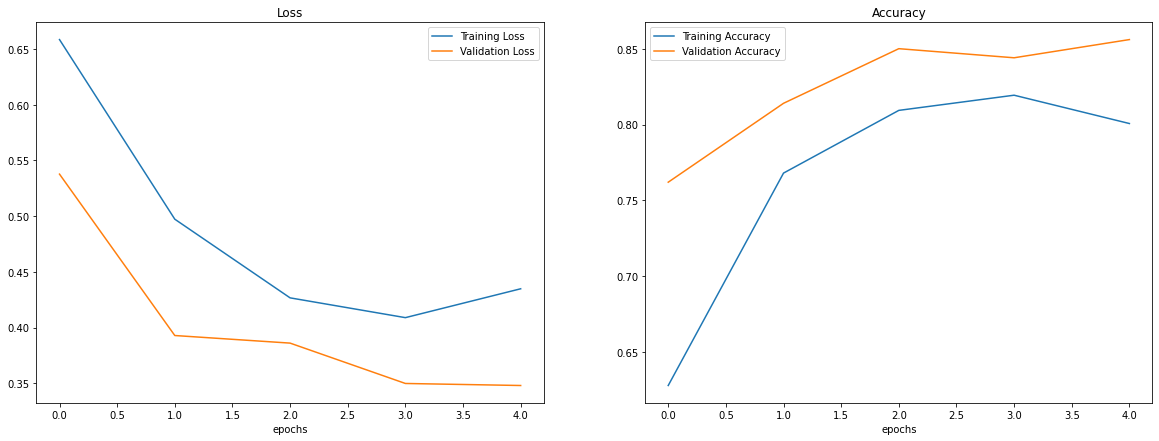

In [92]:
plot_loss_curves(history_5)

***Summary:*** So, after including MaxPool regularization layers in the baseline the number of parameters dropped in **71 times** from 477k to 6.7k. Whereas the accuracy only increased from 75% to 85%, which is incredible! Also, analysing the figures above it is clear that overfitting is no longer present!

## Part: 6 - Updating a model: Data Augmentation

There are many *reasons* to use Data Augmentation, two of them are:

* The main goal when applying data augmentation is to **increase the generalizability** of the model.
* Data Augmentation is one of the way of preventing **overfitting**

> 🔑 **Note:** Data augmentation is usally only performed on the training data.


In [16]:
# Create ImageDataGenerator for training with data augmentation
train_datagen_augmented = ImageDataGenerator(rescale = 1/255.,
                                             rotation_range = 20,     # Rotates an image in range 0-20 degrees
                                             shear_range = 0.2,       # Shears / cropps an image
                                             zoom_range = 0.2,        # Zooms into the image up to +20%
                                             width_shift_range = 0.2, # Shift the image by width
                                             height_shift_range = 0.3,# Shift the image by height
                                             horizontal_flip= True)   # Flips an image horizontally

# Create ImageDataGenerator for training with no data augmentation
train_datagen = ImageDataGenerator(rescale = 1/255.)

# Create ImageDataGenerator for testing data  - preprocessing only, no augmentation
test_datagen = ImageDataGenerator(rescale = 1/255.)

**Data augmentation** is the process of altering our training data, leading to it having more diversity and in turn allowing our models to learn more generalizable patterns. Altering might mean adjusting the rotation of an image, flipping it, cropping it or something similar.

Visualization of data augmentation

In [17]:
# Specify which data to preprocess and augment
# Specify the proper resolution and batch size
train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                         target_size = (224,224,3),
                                                         batch_size = 32,
                                                         class_mode = 'binary',
                                                         shuffle = False)           # Shuffle is False for visualisation only
# Create the same data but with no augmentation
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size = 32,
                                               target_size = (224,224,3),
                                               class_mode = 'binary',
                                               shuffle = False)

# Create testing data with no augmentation
test_data = test_datagen.flow_from_directory(test_dir,
                                             batch_size = 32,
                                             target_size = (224,224,3),
                                             class_mode = 'binary')

Found 1500 images belonging to 2 classes.
Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
